In [1]:
import seisbench.models as sbm
import seisbench
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import torch

# 1 Copy files to the SeisBench cache directory

In [14]:
import seisbench.models as sbm

print(
    f"Copy all files in 'Final_models/volpick/phasenet' to {str(sbm.PhaseNet._pretrained_path('volpick')[0].parent)}"
)
print(
    f"Copy all files in 'Final_models/volpick/eqtransformer' to {str(sbm.EQTransformer._pretrained_path('volpick')[0].parent)}"
)

Copy all files in 'volpick/phasenet' to /home/zhongyiyuan/DATA/seisbench_data/models/v3/phasenet
Copy all files in 'volpick/eqtransformer' to /home/zhongyiyuan/DATA/seisbench_data/models/v3/eqtransformer


# 2 Example

In [3]:
volpick_pn = sbm.PhaseNet.from_pretrained("volpick")
print(volpick_pn.weights_docstring)

Model trained on volcanic earthquakes with a learning rate of 0.0005.
Threshold selected for optimal F1 score on the validation set. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference

Yiyuan Zhong and Yen Joe Tan (2024). Deep-learning-based phase picking for volcano-tectonic and long-period earthquakes, Geophysical Research Letters.


In [4]:
volpick_eqt = sbm.EQTransformer.from_pretrained("volpick")
print(volpick_eqt.weights_docstring)

Model trained on volcanic earthquakes with a learning rate of 0.001.
Threshold selected for optimal F1 score on the validation set. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference

Yiyuan Zhong and Yen Joe Tan (2024). Deep-learning-based phase picking for volcano-tectonic and long-period earthquakes. Geophysical Research Letters.


In [5]:
original_pn = sbm.PhaseNet.from_pretrained("original")
print(original_pn.weights_docstring)

Original PhaseNet model from Zhu et al. (2018). Originally published under MIT License. Original available at https://github.com/AI4EPS/PhaseNet/tree/master/model/190703-214543 . 

Converted to SeisBench by Jannes Münchmeyer (munchmej@univ-grenoble-alpes.fr) with help from Sacha Lapins, Yiyuan Zhong, and Jun Zhu


In [6]:
original_eqt = sbm.EQTransformer.from_pretrained("original")
print(original_pn.weights_docstring)

Original PhaseNet model from Zhu et al. (2018). Originally published under MIT License. Original available at https://github.com/AI4EPS/PhaseNet/tree/master/model/190703-214543 . 

Converted to SeisBench by Jannes Münchmeyer (munchmej@univ-grenoble-alpes.fr) with help from Sacha Lapins, Yiyuan Zhong, and Jun Zhu


In [7]:
# check the current device
print(volpick_pn.device)
# using cuda if possible
if torch.cuda.is_available():
    volpick_pn.cuda()
    volpick_eqt.cuda()
    original_pn.cuda()
    original_eqt.cuda()
# check the current device
print(volpick_pn.device)

cpu
cuda:0


In [12]:
# get data
p_pick = UTCDateTime("2005-05-31T21:05:11.010000Z")
s_pick = UTCDateTime("2005-05-31T21:05:15.580000Z")
t = p_pick - 20
net = "NC"
sta = "MMT"
loc = "--"
cha = "EH"
client = Client("NCEDC")

# t = UTCDateTime("2002-06-23T04:22:08.360000Z") - 10
stream = client.get_waveforms(
    network=net,
    station=sta,
    location="*",
    channel=f"{cha}?",
    starttime=t,
    endtime=t + 70,
)
stream.merge(fill_value=0)
print(stream)
ref_time = min([x.stats.starttime for x in stream])
print(ref_time)

1 Trace(s) in Stream:
NC.MMT..EHZ | 2005-05-31T21:04:52.110000Z - 2005-05-31T21:06:01.000000Z | 100.0 Hz, 6890 samples
2005-05-31T21:04:52.110000Z


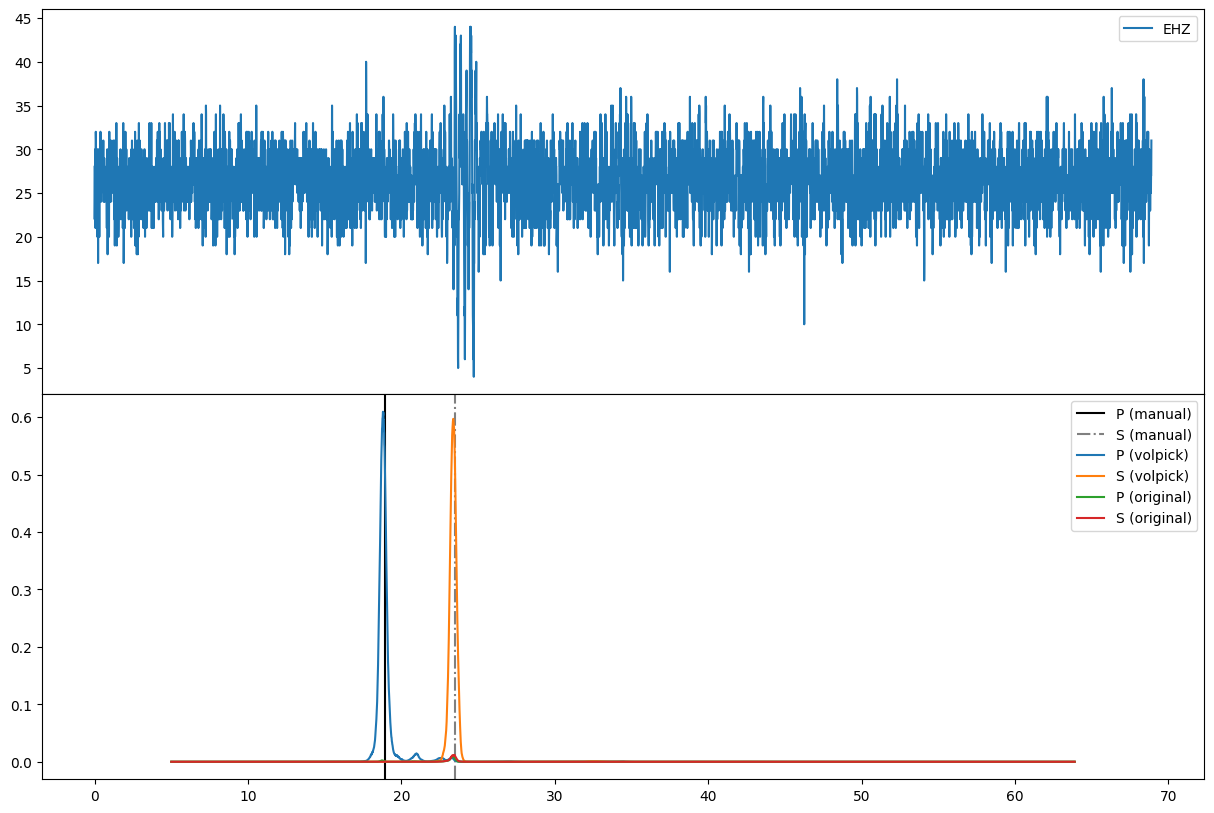

In [13]:
annotations = volpick_pn.annotate(stream, overlap=2500, blinding=[500, 500])
annotations2 = original_pn.annotate(stream, overlap=2500, blinding=[500, 500])

# plot
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0})

ref_time = min([x.stats.starttime for x in stream])
for i in range(len(stream)):
    axs[0].plot(
        stream[i].times(reftime=ref_time), stream[i].data, label=stream[i].stats.channel
    )
axs[1].axvline(p_pick - ref_time, color="black", ls="-", label="P (manual)")
axs[1].axvline(s_pick - ref_time, color="gray", ls="-.", label="S (manual)")
for i in range(3):
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(
            annotations[i].times(reftime=ref_time),
            annotations[i].data,
            label=annotations[i].stats.channel.split("_")[-1] + " (volpick)",
        )
for i in range(3):
    if annotations2[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(
            annotations2[i].times(reftime=ref_time),
            annotations2[i].data,
            label=annotations2[i].stats.channel.split("_")[-1] + " (original)",
        )
axs[0].legend()
axs[1].legend()

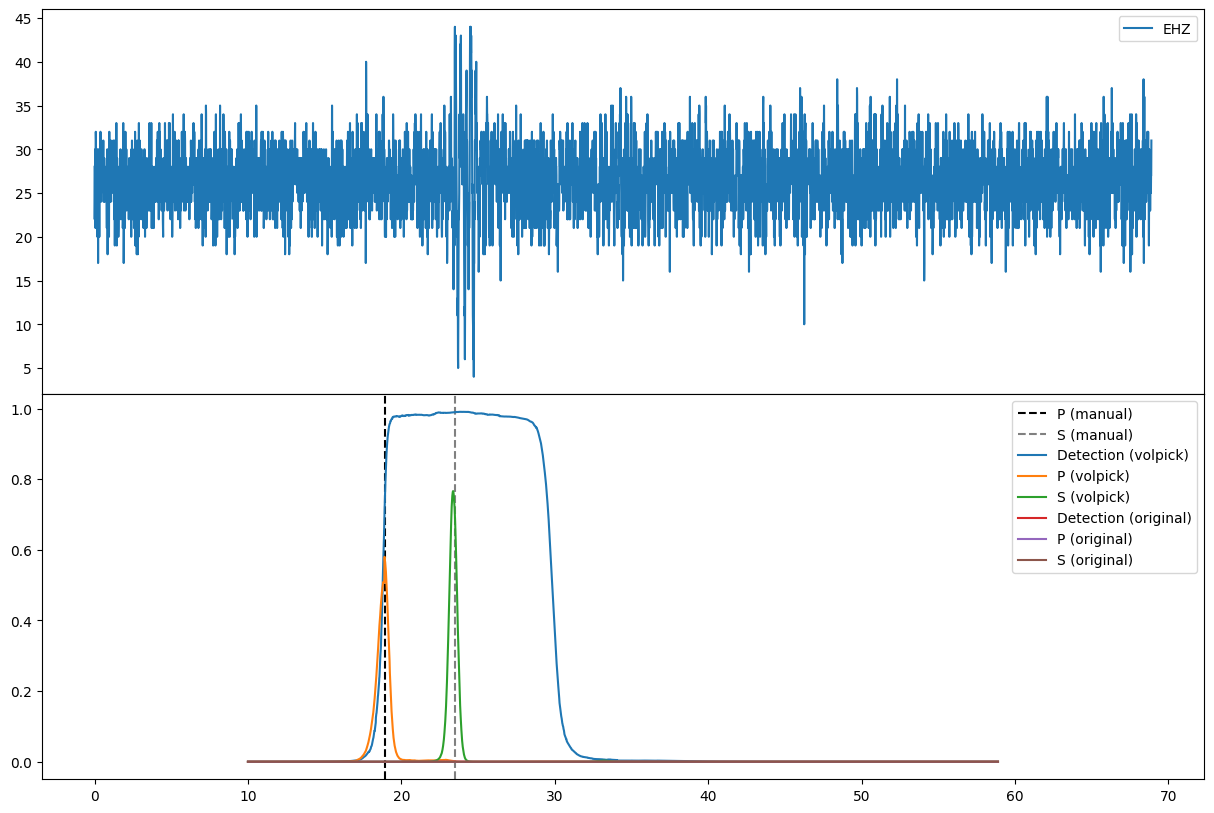

In [23]:
annotations = volpick_eqt.annotate(stream, overlap=4500, blinding=[1000, 1000])
annotations2 = original_eqt.annotate(stream, overlap=4500, blinding=[1000, 1000])

# plot
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0})

ref_time = min([x.stats.starttime for x in stream])
for i in range(len(stream)):
    axs[0].plot(
        stream[i].times(reftime=ref_time), stream[i].data, label=stream[i].stats.channel
    )
axs[1].axvline(p_pick - ref_time, color="black", ls="--", label="P (manual)")
axs[1].axvline(s_pick - ref_time, color="gray", ls="--", label="S (manual)")
for i in range(3):
    # if annotations[i].stats.channel.split("_")[-1] != "Detection":  # Do not plot noise curve
    axs[1].plot(
        annotations[i].times(reftime=ref_time),
        annotations[i].data,
        label=annotations[i].stats.channel.split("_")[-1] + " (volpick)",
    )
for i in range(3):
    # if annotations2[i].stats.channel[-1] != "N":  # Do not plot noise curve
    axs[1].plot(
        annotations2[i].times(reftime=ref_time),
        annotations2[i].data,
        label=annotations2[i].stats.channel.split("_")[-1] + " (original)",
    )
axs[0].legend()
axs[1].legend()

In [24]:
picks = volpick_eqt.classify(
    stream, overlap=1000, blinding=[500, 500], P_threshold=0.15, S_threshold=0.15
)

In [25]:
picks.picks

PickList with 2 entries:

NC.MMT.	2005-05-31T21:05:10.970000Z	P
NC.MMT.	2005-05-31T21:05:15.480000Z	S

In [69]:
p_pick

2005-05-31T21:05:11.010000Z